# Chessformer - Data analysis

## Imports

In [59]:
import duckdb
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

## Data analysis

In [4]:
duckdb.query('''
SELECT *
FROM read_parquet('../data/raw_game_data/*.parquet.zstd')
LIMIT 10
''').df()

,Timestamp,Result,WhiteElo,BlackElo,TimeControl,Termination,NumTokens,Moves
0,2023-05-31 20:00:09-04:00,1-0,1567,1570,180+0,Normal,73,p e2 e4 - p d7 d5 - p e4 d5 - q d8 d5 - n g1 f...
1,2023-05-31 20:00:09-04:00,0-1,1438,1434,180+0,Normal,104,p d2 d4 - p d7 d5 - b c1 g5 - p h7 h6 - b g5 f...
2,2023-05-31 20:00:09-04:00,1-0,1547,1559,180+0,Normal,81,p e2 e3 - p c7 c5 - p d2 d3 - n b8 c6 - b f1 e...
3,2023-05-31 20:00:09-04:00,0-1,1492,1440,180+0,Normal,68,p e2 e4 - p e7 e5 - b f1 c4 - n b8 c6 - n b1 c...
4,2023-05-31 20:00:09-04:00,0-1,2108,2139,180+0,Normal,44,p d2 d4 - p d7 d5 - n g1 f3 - n g8 f6 - b c1 f...
5,2023-05-31 20:00:09-04:00,1-0,1856,1865,180+0,Normal,145,p e2 e4 - p e7 e5 - n g1 f3 - n b8 c6 - p c2 c...
6,2023-05-31 20:00:09-04:00,1-0,1783,1766,180+0,Normal,37,p e2 e4 - p e7 e5 - n g1 f3 - p d7 d6 - b f1 c...
7,2023-05-31 20:00:09-04:00,1/2-1/2,1696,1712,180+0,Normal,77,p e2 e4 - p g7 g5 - n b1 c3 - p g5 g4 - p g2 g...
8,2023-05-31 20:00:09-04:00,0-1,1065,1053,180+0,Normal,56,p d2 d4 - p d7 d5 - n b1 c3 - n g8 f6 - b c1 f...
9,2023-05-31 20:00:09-04:00,0-1,1855,1815,180+0,Normal,48,p e2 e4 - p e7 e5 - n g1 f3 - n b8 c6 - b f1 c...


In [5]:
num_tokens = duckdb.query('''
SELECT NumTokens
FROM read_parquet('../data/raw_game_data/*.parquet.zstd')
''').df()
num_tokens.describe()

,NumTokens
count,4.999955e+06
mean,6.360243e+01
std,2.964187e+01
min,4.000000e+00
25%,4.300000e+01
50%,5.900000e+01
75%,8.000000e+01
max,2.560000e+02


In [9]:
results_frequencies = duckdb.query('''
WITH
    Counts AS (
        SELECT Result, COUNT(*) AS num_instances
        FROM read_parquet('../data/raw_game_data/*.parquet.zstd')
        GROUP BY 1
    )
    SELECT Result, num_instances / (SUM(num_instances) OVER ()) percentage_of_examples
    FROM Counts
    ORDER BY percentage_of_examples DESC
''').df()
results_frequencies

,Result,percentage_of_examples
0,1-0,0.498497
1,0-1,0.454269
2,1/2-1/2,0.047234


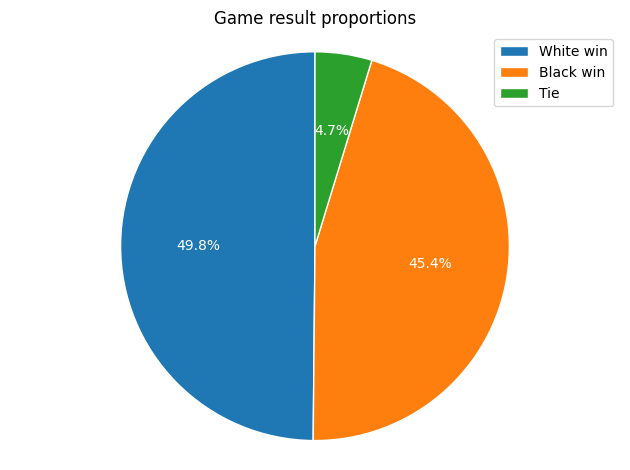

In [38]:
sizes = results_frequencies["percentage_of_examples"]
labels = results_frequencies["Result"].map({"1-0": "White win", "0-1": "Black win", "1/2-1/2": "Tie"})
patches, text, _ = plt.pie(sizes,
                           autopct='%1.1f%%',
                           startangle=90,
                           wedgeprops = { 'linewidth' : 1, 'edgecolor' : 'white' },
                           textprops={"color": "w"})
plt.title("Game result proportions")
plt.legend(patches, labels, loc="best")
# Set aspect ratio to be equal so that pie is drawn as a circle.
plt.axis("equal")
plt.tight_layout()
plt.savefig("game_results.png")
plt.show()

In [34]:
white_elo = duckdb.query('''
SELECT WhiteElo
FROM read_parquet('../data/raw_game_data/*.parquet.zstd')
''').df()
white_elo.describe()

,WhiteElo
count,4.999955e+06
mean,1.722666e+03
std,3.565241e+02
min,4.000000e+02
25%,1.486000e+03
50%,1.743000e+03
75%,1.971000e+03
max,3.170000e+03


In [35]:
black_elo = duckdb.query('''
SELECT BlackElo AS elo
FROM read_parquet('../data/raw_game_data/*.parquet.zstd')
''').df()
black_elo.describe()

,BlackElo
count,4.999955e+06
mean,1.722605e+03
std,3.565775e+02
min,4.000000e+02
25%,1.486000e+03
50%,1.743000e+03
75%,1.970000e+03
max,3.046000e+03


In [77]:
white_elo = duckdb.query('''
SELECT WhiteElo AS Elo
FROM read_parquet('../data/raw_game_data/*.parquet.zstd')
''').df()

white_elo.insert(0, "Type", ["White Elo"] * len(white_elo.index))

black_elo = duckdb.query('''
SELECT BlackElo AS Elo
FROM read_parquet('../data/raw_game_data/*.parquet.zstd')
''').df()

black_elo.insert(0, "Type", ["Black Elo"] * len(black_elo.index))

elos = pd.concat([white_elo, black_elo], axis=0, ignore_index=True)

elos.head()

,Type,Elo
0,White Elo,1567
1,White Elo,1438
2,White Elo,1547
3,White Elo,1492
4,White Elo,2108


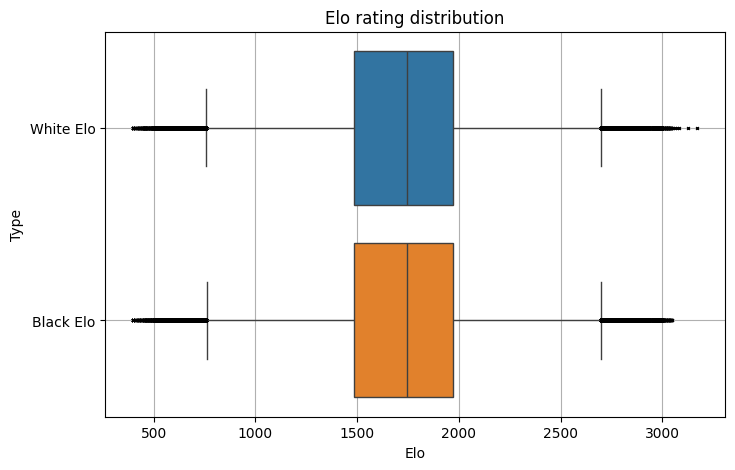

In [104]:
fig, axis = plt.subplots(1, 1, figsize=(8, 5))
flierprops = dict(marker='x', markerfacecolor='None', markersize=2,  markeredgecolor='black')
sns.boxplot(
    data=elos,
    x="Elo",
    y="Type",
    hue="Type",
    orient="h",
    flierprops=flierprops,
    ax=axis
)
axis.set_title("Elo rating distribution")
axis.grid(True)
plt.savefig("elo_distribution")
plt.show()

In [105]:
num_tokens = duckdb.query('''
SELECT NumTokens
FROM read_parquet('../data/raw_game_data/*.parquet.zstd')
''').df()
num_tokens.describe()

,NumTokens
count,4.999955e+06
mean,6.360243e+01
std,2.964187e+01
min,4.000000e+00
25%,4.300000e+01
50%,5.900000e+01
75%,8.000000e+01
max,2.560000e+02


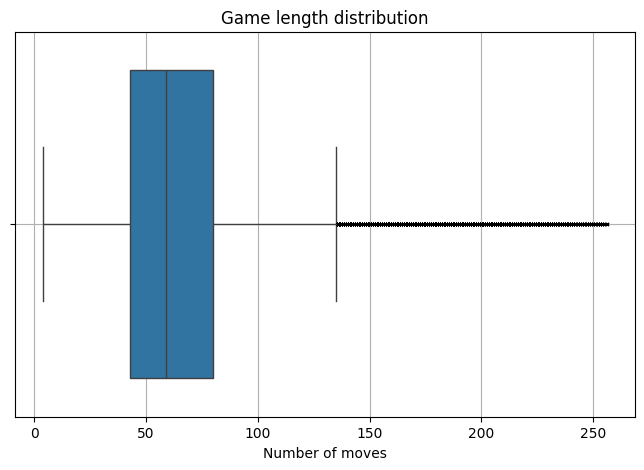

In [103]:
fig, axis = plt.subplots(1, 1, figsize=(8, 5))
flierprops = dict(marker='x', markerfacecolor='None', markersize=2,  markeredgecolor='black')
sns.boxplot(
    data=num_tokens,
    x="NumTokens",
    orient="h",
    flierprops=flierprops,
    ax=axis
)
axis.set_title("Game length distribution")
axis.set_xlabel("Number of moves")
axis.grid(True)
plt.savefig("game_length_distribution.png")
plt.show()

In [19]:
num_tokens = duckdb.query('''
SELECT NumTokens
FROM read_parquet('data/raw_game_data/*.parquet.zstd')
WHERE Result = '1-0'
''').df()
num_tokens.describe()

,NumTokens
count,2.492462e+06
mean,6.068281e+01
std,2.810646e+01
min,4.000000e+00
25%,4.100000e+01
50%,5.700000e+01
75%,7.500000e+01
max,2.510000e+02


In [21]:
num_tokens = duckdb.query('''
SELECT NumTokens
FROM read_parquet('data/raw_game_data/*.parquet.zstd')
WHERE Result = '0-1'
''').df()
num_tokens.describe()

,NumTokens
count,2.271323e+06
mean,6.270003e+01
std,2.809030e+01
min,4.000000e+00
25%,4.400000e+01
50%,5.800000e+01
75%,7.800000e+01
max,2.540000e+02


In [22]:
num_tokens = duckdb.query('''
SELECT NumTokens
FROM read_parquet('data/raw_game_data/*.parquet.zstd')
WHERE Result = '1/2-1/2'
''').df()
num_tokens.describe()

,NumTokens
count,236170.000000
mean,103.093822
std,31.914267
min,4.000000
25%,82.000000
50%,105.000000
75%,124.000000
max,256.000000
